In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

/Users/anna/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

In [2]:
excel = pd.ExcelFile('HainanClean_New.xlsx')
hainan = excel.parse("fulldf")
hainan
hainan.columns = hainan.columns.str.replace('  ', '_')
hainan.columns = hainan.columns.str.replace(' ', '_')
hainan.columns = hainan.columns.str.replace('(', '')
hainan.columns = hainan.columns.str.replace('（', '')
hainan.columns = hainan.columns.str.replace(')', '')

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
hainan.Month = hainan.Month.map(d)
hainan.BioCNG_Produced_Nm3 = hainan.BioCNG_Produced_m3.shift(-15)
hainan.drop(hainan.tail(15).index,inplace=True)
hainan = hainan[np.isfinite(hainan['Month'])]
hainan.columns
hainan = hainan[np.isfinite(hainan['Lemon_waste_t'])]
hainan = hainan[np.isfinite(hainan['Percolate_t'])]
hainan = hainan.replace(' ',0)
hainan = hainan.replace('',0)
hainan = hainan.replace('  ',0)
hainan = hainan.drop(['Year', 'Month', 'Day', 'Month_#', 'Day_#', 'Raw_Biogas_Produced_m3', 'BioCNG_Sold_m3', 'Vehicle_use_m3',
       'Liquid_Fertilizer_Produced_t', 'Solid_fertilizer_produced_t',
       'Wastewater_flow_to_WWTP_unit?', 'Solid_residues_kg','50%_NaOH/kg', 'FeCl2/kg', 'PAM/kg',
       'Defoamer/kg', 'Project_electricity_use/kWh',
       'Office_space_electricity_use/kWh', 'Water/m3', 'Diesel/L'], axis=1)
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.44
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,28.92
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.90
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


# Preliminary Work

In [3]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))

train data len: 1098
test data len: 275


In [4]:
for col in hainan.columns[1:]:
    hainan['1/'+col] = 1/(hainan[col])
hainan.head()
hainan.replace(float('inf'), 0, inplace=True)
hainan.columns

Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t'],
      dtype='object')

In [5]:
for col in hainan.columns[1:]:
    hainan[col+"**2"] = (hainan[col])**2
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t**2,1/Chicken_litter_t**2,1/Bagasse_feed_t**2,1/Alcohol_waste_t**2,1/Chinese_medicine_waste_t**2,1/Energy_grass_t**2,1/Banana_fruit_shafts_t**2,1/Lemon_waste_t**2,1/Percolate_t**2,1/Other_waste_t**2
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001430
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001196
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001382
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.012346,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [6]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))
hainan.head()
hainan.columns

train data len: 1098
test data len: 275


Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
   

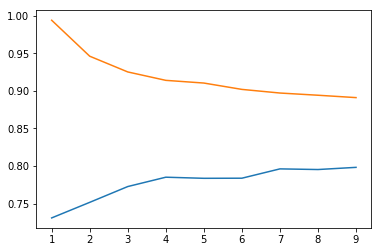

Accuracy of kNN on train set: 0.90
Accuracy of kNN on test set: 0.80


In [7]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:62]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:62]
ynor_test = hainan_normalized_test[0]
scoretest = []
scoretrain = []
for n in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(Xnor_train, ynor_train)
    y_pred_test = knn.predict(Xnor_test)
    scoretest.append(knn.score(Xnor_test, ynor_test))
    scoretrain.append(knn.score(Xnor_train, ynor_train))
    #print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
    #print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))
plt.plot(range(1,10), scoretest)
plt.plot(range(1,10), scoretrain)
plt.show()

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xnor_train, ynor_train)

print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))

In [8]:
hainan.loc[hainan['BioCNG_Produced_m3'].idxmax()]
hainan.loc[hainan['BioCNG_Produced_m3'].idxmin()]
y_pred_test = y_pred_test*15100


In [9]:
y_pred_test

array([  3368.33333333,   1867.        ,   3400.44444444,   3220.44444444,
        12598.66666667,  10952.74333333,   3499.55555556,   3475.77777778,
         2660.33333333,   4437.        ,   3457.33333333,   3984.88888889,
         2729.33333333,   1498.        ,   1690.77777778,   6279.66666667,
         3599.55555556,   4976.77777778,   8699.44444444,   2189.        ,
         8287.44444444,   2813.33333333,    623.33333333,    566.33333333,
        10063.11111111,  12164.66666667,   2647.33333333,   7393.44444444,
         5139.11111111,   1820.        ,  12562.33333333,   4632.77777778,
        11487.44444444,   3383.66666667,   8933.        ,   2124.66666667,
         9040.88888889,   2647.88888889,   4396.33333333,   3339.        ,
         4258.88888889,   3595.44444444,   4609.22222222,   3709.        ,
         5087.11111111,   3439.77777778,   2963.55555556,   1869.11111111,
         2774.22222222,   7929.77777778,   3992.22222222,   2082.11111111,
          566.33333333,  

In [10]:
#Feature importance
knn = KNeighborsRegressor(n_neighbors=7)
feature_scores = []
n = len(hainan.columns)-1
for i in range(1,n):
    Xi = Xnor_train[i].reshape(-1, 1)
    Xj = Xnor_test[i].reshape(-1, 1)    
    knn.fit(Xi, ynor_train.reshape(-1, 1))
    y_pred_test = knn.predict(Xj)
    feature_scores.append(knn.score(Xj, ynor_test))

important_feature = pd.DataFrame(feature_scores)
important_feature['index'] = range(n-1)
important_feature = important_feature.sort_values(by=0, ascending=False).iloc[0:10]
features = hainan.columns[1:n]
f = []
for i in important_feature['index']:
    f.append(features[i])
important_feature['feature'] = f
important_feature.drop(['index'], axis=1, inplace=True)
important_feature.columns = ['accuracy_score', 'feature']
important_feature = important_feature.reindex_axis(['feature','accuracy_score'], axis=1)
important_feature

/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


,feature,accuracy_score
18,1/Kitchen_food_waste_t,0.600427
48,1/Kitchen_food_waste_t**2,0.599740
58,1/Percolate_t**2,0.582879
28,1/Percolate_t,0.581254
13,Percolate_t,0.565460
43,Percolate_t**2,0.558981
4,Municipal_fecal_residue_t,0.523232
19,1/Municipal_fecal_residue_t,0.523073
49,1/Municipal_fecal_residue_t**2,0.522428
34,Municipal_fecal_residue_t**2,0.522358
